# Multi-Armed Bandit

In this notebook, an agent is trained to solve a stationary and a restless Multi-Armed Bandit problem.

The code is adapted from NYU's 'Computational Cognitive Modeling' course to accomplish the homework assignment. 


# Outline
- [ 1 - Import Packages <img align="Right" src="https://m.media-amazon.com/images/I/71UAyY3PJBL._AC_UF894,1000_QL80_.jpg" width = 20% length = 30%>](#1)
- [ 2 - Load the Environment](#2)
- [ 3 - Main Functions](#3)
- [ 4 - Helper Functions](#4)
- [ 5 - Train the Agent](#5)

<a name="1"></a>
## 1 - Import Packages

In [3]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt 
import random
import math
import seaborn as sns

<a name="2"></a>
## 2 - Load the Environment

In [2]:
class KArmBanditStationary():
    def __init__(self, mus, sds):
        """
        mus and sds are lists of mean and standard deviation of the distributions for each arm. Each list has k numbers for the k-armed bandit.
        """
        self.action_means = mus
        self.action_sds = sds
        self.optimal = np.argmax(self.action_means)
        self.k = len(mus)
        
    def step(self, action):
        return np.random.normal(self.action_means[action], self.action_sds[action]), action==self.optimal

In [13]:
# On each time step, the mean reward of each action should be modified up or down by a sample from a Gaussian distribution
class KArmBanditRestless():
    def __init__(self, k, mu=0, sigma=2, sd=2, walk_sd=30):
        self.k = k
        self.action_means = np.random.normal(mu, sigma, k)
        self.action_sds = sd
        self.walk_sd = walk_sd
        self.optimal = np.argmax(self.action_means)
        
    def step(self, action):
        out = np.random.normal(self.action_means[action], self.action_sds), action==self.optimal
        self.action_means = self.action_means + np.random.normal(0.0, self.walk_sd, self.k)
        self.optimal = np.argmax(self.action_means)
        return out

<a name="3"></a>
## 3 - Main Functions

In [6]:
class RandomAgent():
    def __init__(self, k):
        self.num_actions = k
        pass
    
    def choose(self):
        return np.random.randint(self.num_actions)
    
    def learn(self, reward, action): # this agent doesn't learn
        pass

In [8]:
class EpsilonGreedyAgentIncremental():
    def __init__(self, k, epsilon): 
        self.num_actions = k
        self.epsilon = epsilon 
        pass
    
    def choose(self, max_arm_value):
        if random.random() < self.epsilon:
            return np.random.randint(self.num_actions) 
        else:      
            return max_arm_value[0] 
            
    def learn(self, reward, choice, N_value): 
        if choice in N_value.keys():
            N = N_value[choice][0]
            value = N_value[choice][1] 
            N_value[choice][1] = value + 1 / N * (reward - value)
            N_value[choice][0] += 1
        else: 
            N_value[choice] = [1, reward]
        return N_value

<a name="4"></a>
## 4 - Helper Functions

In [7]:
# Function to plot the reward history including a smoothed average reward earned by the agents over the last 30 trials
def plot_results(results_df, window=25):
    # set up figiure
    palette = iter(sns.color_palette("Set2"))
    fig = plt.figure(constrained_layout=True,figsize=(18,5))
    gs = fig.add_gridspec(2,5)
    
    # add three axes
    rew_ax  = fig.add_subplot(gs[0,:-2]) 
    opt_ax  = fig.add_subplot(gs[1,:-2])
    runs_ax = fig.add_subplot(gs[:,-2:])
    
    #fig, (rew_ax,opt_ax) = plt.subplots(nrows=2,ncols=1,figsize=(18,8))
    smooth_df = results_df.groupby('run').rolling(window,on='timepoint').mean()
    sns.lineplot(x='timepoint',y='reward_history', data=smooth_df, ax=rew_ax, label='reward', color=next(palette))
    rew_ax.legend(loc="upper right")

    sns.lineplot(x='timepoint',y='opt', data=smooth_df, ax=opt_ax, label='p(optimal)', color=next(palette))
    opt_ax.set_ylim(0,1)
    opt_ax.legend(loc="upper right")
    
    sns.distplot(results_df.groupby('run')['opt'].mean(), ax=runs_ax, color=next(palette))
    runs_ax.set_title("proportion optimal choices across runs")
    runs_ax.set_xlim(0,1)
    

<a name="5"></a>
## 5 - Train the Agent

### Stantionary Multi-Armed Bandit 

/var/folders/1n/97rlgs_n2y99xylp3q9q_d840000gn/T/ipykernel_5353/2737271620.py:22: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results_df.groupby('run')['opt'].mean(), ax=runs_ax, color=next(palette))


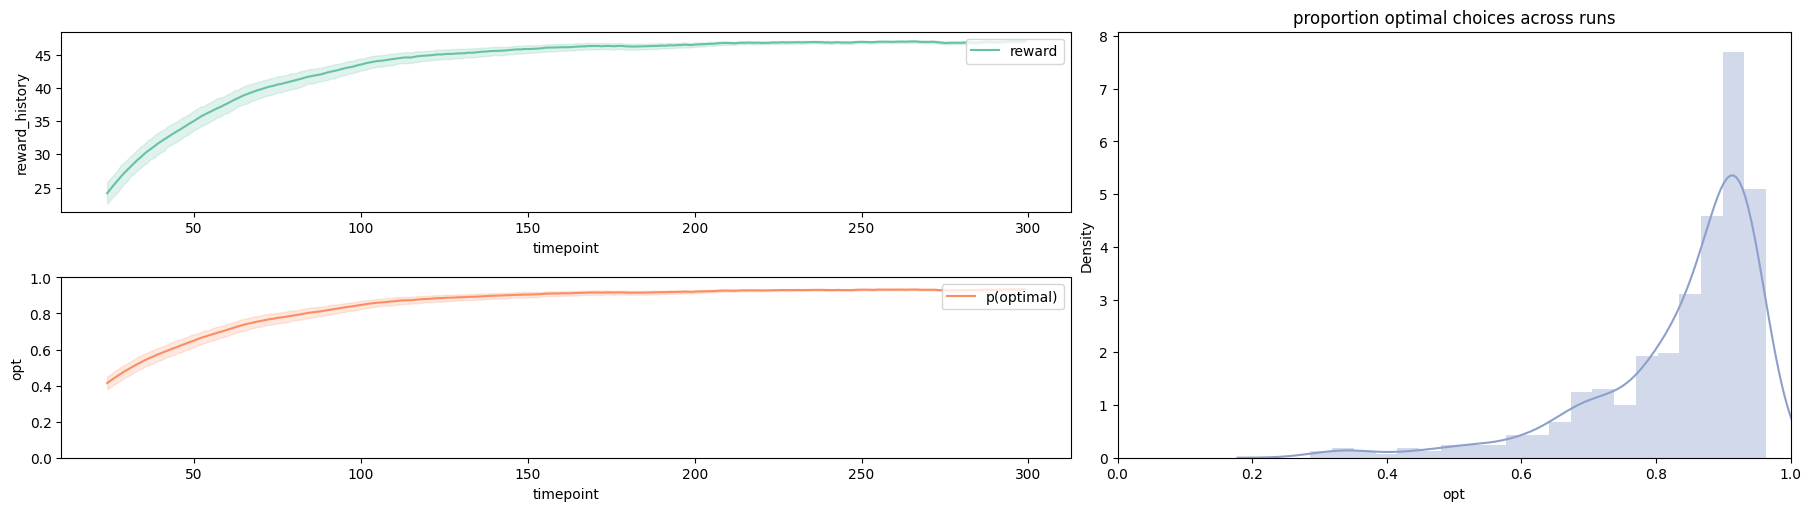

In [9]:
np.random.seed(100) # fix a seed for repeatable experiments

# parameters of simulation
epsilon = 0.09
n_timesteps = 300
n_runs = 500

# set up bandit options
n_bandits = 4
bandit_means = [0,50,10,4]
bandit_sds = [1]*n_bandits

reward_history = []
opt_history = []
run_history = []
timestep = []

for run in range(n_runs):  # repeat a given number random repetitions of the experiment
    # make first choice randomly 
    np.random.shuffle(bandit_means) # randomize location of "best"
    bandit = KArmBanditStationary(bandit_means,bandit_sds) # create a new bandit
    N_value = {} # keys are the arms. Values of the dictionary are a list of [N, value]
    
    for i in range(n_timesteps): 
        # let the agent choose randomly for the first step 
        if i == 0:
            agent = RandomAgent(n_bandits)
            choice = agent.choose() 
            reward, opt = bandit.step(action = choice)
            # update value 
            N_value[choice] = [1, reward]              
            # update max 
            max_arm_value = [choice, reward]
        else:
            agent = EpsilonGreedyAgentIncremental(n_bandits, epsilon)  
            choice = agent.choose(max_arm_value) 
            reward, opt = bandit.step(action = choice)
            # update value 
            N_value = agent.learn(reward, choice, N_value)   
            # update max 
            if len(N_value) == 1:
                max_arm_value = [choice, N_value[choice][1]]
            else:
                for key in N_value.keys():
                    if N_value[key][1] > max_arm_value[1]:
                        max_arm_value = [key, N_value[key][1]]
                          
        reward_history.append(reward)
        opt_history.append(opt)
        run_history.append(run)
        timestep.append(i)
        
# plot the results
sim_result_df=pd.DataFrame({"run": run_history, "timepoint": timestep, "reward_history":reward_history, "opt": opt_history})
plot_results(sim_result_df)

### Restless Multi-Armed Bandit 

/var/folders/1n/97rlgs_n2y99xylp3q9q_d840000gn/T/ipykernel_5353/2737271620.py:22: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results_df.groupby('run')['opt'].mean(), ax=runs_ax, color=next(palette))


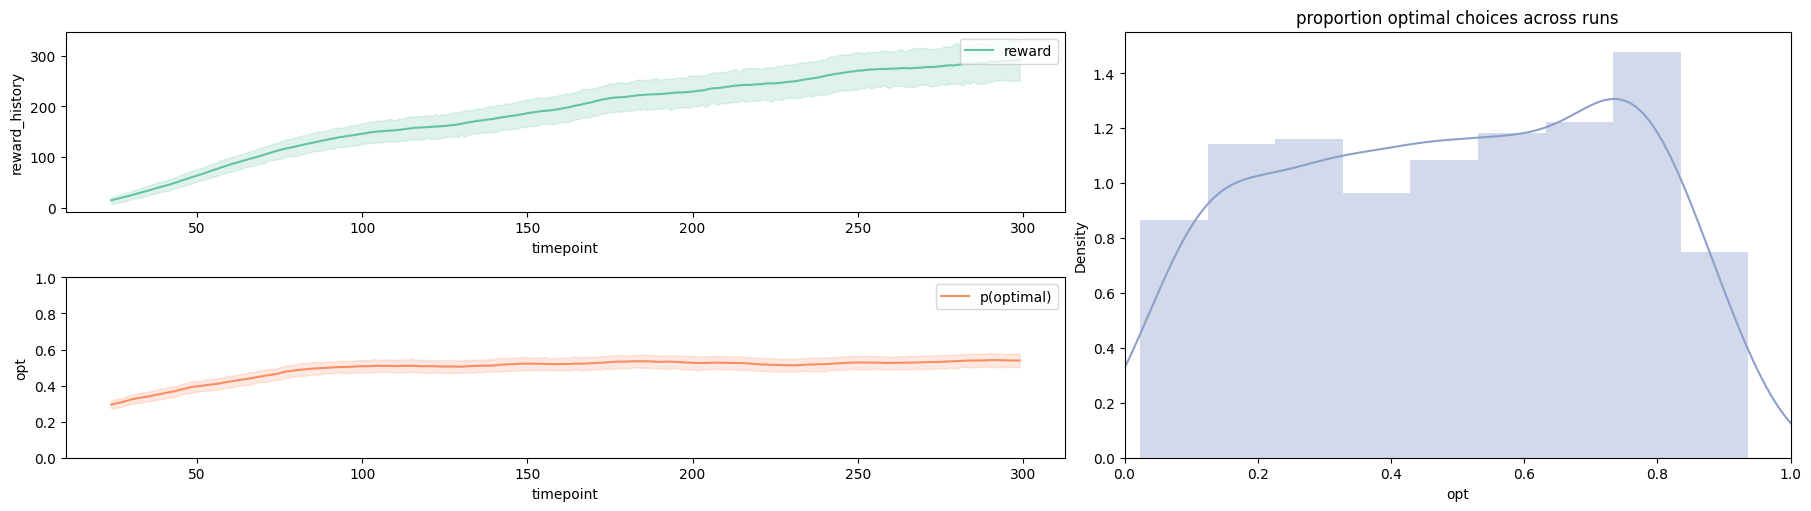

In [14]:
np.random.seed(100) # fix a seed for repeatable experiments

# parameters of simulation
epsilon = 0.09
n_timesteps = 300
n_runs = 500

# set up bandit options
n_bandits = 4

reward_history = []
opt_history = []
run_history = []
timestep = []

for run in range(n_runs):  # repeat a given number random repetitions of the experiment
    # make first choice randomly 
    np.random.shuffle(bandit_means) # randomize location of "best"
    bandit = KArmBanditRestless(n_bandits) # create a new bandit
    N_value = {} # keys are the arms. Values of the dictionary are a list of [N, value]
    
    for i in range(n_timesteps): 
        # let the agent choose randomly for the first step 
        if i == 0:
            agent = RandomAgent(n_bandits)
            choice = agent.choose() 
            reward, opt = bandit.step(action = choice)
            # update value 
            N_value[choice] = [1, reward]              
            # update max 
            max_arm_value = [choice, reward]
        else:
            agent = EpsilonGreedyAgentIncremental(n_bandits, epsilon)  
            choice = agent.choose(max_arm_value) 
            reward, opt = bandit.step(action = choice)
            # update value 
            N_value = agent.learn(reward, choice, N_value)   
            # update max 
            if len(N_value) == 1:
                max_arm_value = [choice, N_value[choice][1]]
            else:
                for key in N_value.keys():
                    if N_value[key][1] > max_arm_value[1]:
                        max_arm_value = [key, N_value[key][1]]
                          
        reward_history.append(reward)
        opt_history.append(opt)
        run_history.append(run)
        timestep.append(i)
        
# plot the results
sim_result_df=pd.DataFrame({"run": run_history, "timepoint": timestep, "reward_history":reward_history, "opt": opt_history})
plot_results(sim_result_df)